In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../dataset/data0test.txt'
data0Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;
apram=0.1*pi
feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(apram*Parameter('x[0]'),0)
feature_map.rx(apram*Parameter('x[1]'),1)
feature_map.rx(apram*Parameter('x[2]'),2)
feature_map.rx(apram*Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [6]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [7]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

C:\Users\Saesun Kim\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


51.509437561035156
53.571022033691406
50.02448272705078
50.01376724243164
50.013614654541016
50.01359939575195
50.01305389404297
50.012210845947266
50.010276794433594
50.007835388183594
50.00313186645508
50.00288391113281
50.002593994140625
50.00228500366211
50.00199890136719
50.00105285644531
50.36027908325195
50.000701904296875
50.00057601928711
50.00049591064453


tensor(51.5094, grad_fn=<AddBackward0>)

Accuracy: 0.47


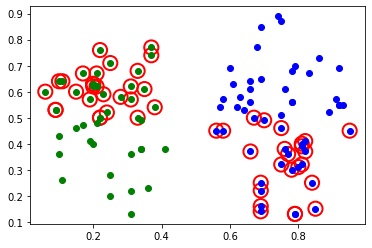

In [8]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

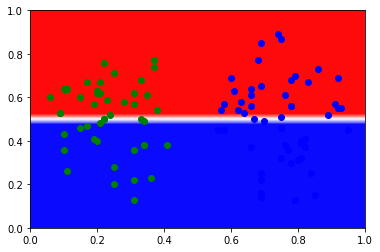

In [9]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [10]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = optim.SGD(model2.parameters(),lr=1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 50     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()


50.90277862548828
59.34975814819336
50.10749053955078
50.2224006652832
50.830745697021484
51.68791198730469
50.32572555541992
51.57647705078125
50.40092468261719
54.72689437866211
58.68606185913086
53.107078552246094
51.10956573486328
55.02403259277344
50.07006072998047
51.596954345703125
50.0950927734375
65.15325164794922
51.843528747558594
50.78173828125
50.76351547241211
73.41921997070312
59.8743782043457
50.005615234375
50.0047721862793
50.00398635864258
50.00267791748047
50.00175857543945
50.001338958740234
50.00105667114258
50.000831604003906
50.000648498535156
50.00051498413086
50.00041580200195
50.0003547668457
50.000308990478516
50.0002555847168
50.00022888183594
50.00020217895508
50.00018310546875
50.00017547607422
50.00017166137695
50.00016784667969
50.00016403198242
50.00015640258789
50.000152587890625
50.000152587890625
50.00014114379883
50.00013732910156
50.00013732910156


Accuracy: 0.54


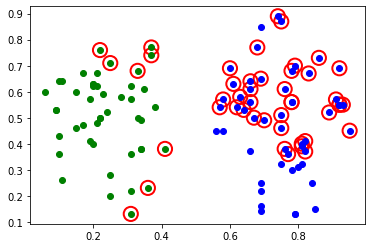

In [11]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

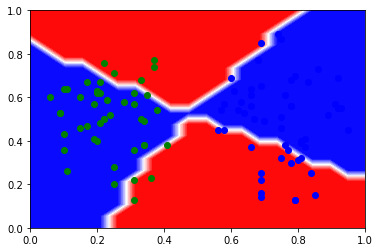

In [12]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [13]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define optimizer and loss function
optimizer = optim.Adam(model2.parameters(), lr=0.1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 100     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()

54.16831970214844
51.406429290771484
50.29850769042969
50.03007125854492
50.00040054321289
50.0001220703125
50.00782775878906
50.0451545715332
50.11433792114258
50.18090057373047
50.20696258544922
50.18575668334961
50.1379508972168
50.08769989013672
50.04850387573242
50.023216247558594
50.00928497314453
50.00303649902344
50.00137710571289
50.00230026245117
50.00448226928711
50.00711441040039
50.00969696044922
50.01195526123047
50.01370620727539
50.01485061645508
50.01537322998047
50.01532745361328
50.01482391357422
50.013916015625
50.012752532958984
50.01142501831055
50.010047912597656
50.008705139160156
50.00743865966797
50.006282806396484
50.005279541015625
50.00439453125
50.0036506652832
50.00301742553711
50.00249481201172
50.0020637512207
50.00170135498047
50.001426696777344
50.00117492675781
50.000999450683594
50.00083923339844
50.00069808959961
50.000587463378906
50.00051498413086
50.00043487548828
50.0003776550293
50.000335693359375
50.00029373168945
50.00025177001953
50.0002326

Accuracy: 0.46


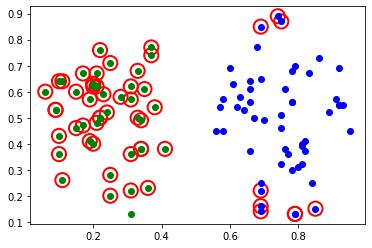

In [14]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

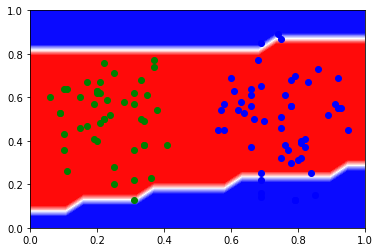

In [15]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)